# statistical comparisons

Notebook to run post-hoc pairwise statistical comparisons between methods on the ground-truth and black-box regression problems.

In [1]:
from scipy.stats import wilcoxon 
import pandas as pd
import itertools as it
import os
import seaborn as sns
sns.set(font_scale=1.5, style='white')

figdir = 'figs/stats/'
rdir = '../results/'

print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.png')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')

figdir: figs/stats/


In [2]:
import pdb
import numpy as np

def pairwise_pval(df, metric, alg1, alg2):
    df = df.loc[df.algorithm.isin([alg1, alg2]),:].copy()
    x = df.loc[df.algorithm==alg1, metric].values 
    y = df.loc[df.algorithm==alg2, metric].values 
    eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
    if metric.endswith('norm'):
        rmetric = metric.replace('norm','rank')
    else:
        rmetric = metric+'_rank'
    if rmetric not in df.columns:
        rmetric = metric
        
    x_rank = df.loc[df.algorithm==alg1, rmetric].values 
    y_rank = df.loc[df.algorithm==alg2, rmetric].values 
#     pdb.set_trace()
    if len(x) != len(y):
        print(alg1, len(x))
        print(alg2, len(y))
    assert len(x) == len(y)
#     w, p = mannwhitneyu(x, y)
    if all(y==0) and all(x==0):
        return 1, 1
    
    w, p = wilcoxon(x, y)
    return p, eff_size

#     return pstr, eff_size_str

def signif(pval, alpha, eff):
    pstr = '{:1.2g}'.format(pval)
    eff_size_str = '{:1.1f}X'.format(eff)
    if pval == '-': return pval
    if float(pval) < alpha:
        return 'textbf{'+pstr+'}', 'textbf{'+eff_size_str+'}'
#         return pval+'*'
    else:
        return pstr, eff_size_str
    
def get_pval_df(df, metric, all_algs):
    df = df.copy()
    n=0
    pvals = []
    for alg1, alg2 in it.combinations(all_algs, 2):
        pval, eff_size = pairwise_pval(df, metric, alg1, alg2)
        pvals.append(dict(
            alg1 = alg1,
            alg2 = alg2,
            eff_size = eff_size,
            pval = pval
        ))
        n += 1
    c_alpha = alpha/n


    print('n:',n,'c_alpha:',c_alpha) 
    df_pvals = pd.DataFrame.from_records(pvals)
    # df_pvals['pval_thresh'] = pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    df_pvals['pval_thresh'] = df_pvals['pval'].apply(lambda x: bin_pval(x, c_alpha))

    # significance
    df_pvals.loc[:,'pval_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
                                                                      c_alpha,
                                                                      x['eff_size'])[0],
                                                     axis=1
                                                    )
    df_pvals.loc[:,'eff_size_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
                                                                      c_alpha,
                                                                      x['eff_size'])[1],
                                                     axis=1
                                                    )
    return df_pvals, c_alpha

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

def bin_pval(x, c_alpha):

    for stars,level in zip([4,3,2,1],[1e-3, 1e-2, 1e-1, 1]):
        if x < level*c_alpha: 
            return stars #level #*c_alpha
    return 0

def pval_heatmap(df, metric, problem, algs):
    df = df.copy()
    n = 0 
    pvals = []

    df_pvals, c_alpha = get_pval_df(df, metric, algs)
    
    #                                                  pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    tbl = df_pvals.set_index(['alg1','alg2'])['pval_thresh'].unstack().transpose() #.fillna('-')

    mask = np.zeros_like(tbl, dtype=bool)
    mask[np.triu_indices_from(mask,k=1)] = True

    h = plt.figure(figsize=(10,10))

    cmap = sns.color_palette('flare',n_colors=5)
    cmap[0] = [.9, .9, .9]
    ax = sns.heatmap(tbl, 
                linewidth=0.25,
                mask=mask,
                square=True,
                cbar_kws=dict(
                              ticks = [0.4, 1.2, 2.0, 2.8, 3.6],
                              shrink=0.6,
                ),
                cmap=cmap,

               )
    cax = h.axes[-1]
    cbar_labels = [
                   'no significance',
                   '$p<\\alpha$',
                   '$p<$1e-1$\cdot \\alpha$',
                   '$p<$1e-2$\cdot \\alpha$',
                   '$p<$1e-3$\cdot \\alpha$',
                  ]
    cax.set_yticklabels(cbar_labels)
    nice_metric = metric.replace('%','pct').replace('_',' ').replace('R2','$$R^2$$').title()
    plt.title(('Wilcoxon signed-rank test, '
              +nice_metric
              +', $\\alpha =$ {:1.1e}').format(c_alpha)
             )
    plt.xlabel('')
    plt.ylabel('')
    savename = ('Pairwise comparison of '
              +nice_metric
              +' on '
              +problem).replace(' ','_')
    save(h, savename)

# symbolic datasets

## load data and fill nan results

In [4]:
df_sum = pd.read_csv(rdir+'/symbolic_dataset_results_sum.csv.gz')
algs = df_sum.algorithm.unique()
datasets = df_sum.dataset.unique()
noises = df_sum.target_noise.unique()

df_sum
cols = df_sum.columns
for col in [c for c in cols if 'rank' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(len(algs)+1)
for col in [c for c in cols if 'solution_rate' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(0.0)

In [5]:
cols = df_sum.columns
filler_frame = {
    'r2_test' : 0.0,
    'solution_rate_(%)' : 0.0,
}
fill_frames = []

for dataset in datasets:
    for noise in noises:
        for alg in algs:
            df = df_sum.loc[df_sum.dataset == dataset].loc[df_sum.target_noise==noise]
            if alg not in df.algorithm.unique():
                new_fill = filler_frame.copy()
                new_fill.update({
                                 'algorithm':alg,
                                 'dataset':dataset,
                                 'target_noise':noise
                                })
                fill_frames.append(new_fill)
df_fill = pd.DataFrame.from_records(fill_frames, columns=fill_frames[0].keys()) 
df_sum_filled = df_sum.append(df_fill)


/tmp/ipykernel_914689/151884592.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sum_filled = df_sum.append(df_fill)


## generate tables

In [6]:
alpha = 0.05
SR_pvals = {}

for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
    for target_noise, dfg in df_sum_filled.groupby('target_noise'):
        print(metric, 'noise=',target_noise)
        df_pvals, c_alpha = get_pval_df(df_sum_filled, metric, algs) 

        pval_tbl = df_pvals.set_index(['alg1','alg2'])['pval_bold'].unstack().fillna('-')
        disp_tbl = df_pvals.set_index(['alg1','alg2'])['pval'].unstack().fillna('-')
        SR_pvals[metric] = {target_noise:disp_tbl}
        display(disp_tbl)

        pval_tbl

r2_test noise= 0.0
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,0.000415,0.0,0.0,0.0,0.0,0.0,0.327005,0.0,0.0,0.002851,0.0,0.0,0.0,0.037854,0.0,0.0,1.207877e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.010307,0.0,0.673466,0.0,0.0,0.0,0.0,0.049753,0.0,0.0,3.201922e-60
AIFeynman,-,-,0.647376,0.604635,0.000539,0.036309,0.943422,0.000001,0.020042,0.000004,0.000387,0.064769,0.0,0.008687,0.000004,0.0,0.0,3.657806e-02
BSR,-,-,-,0.475875,0.0,0.0,0.009078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477174e-26
Baseline,-,-,-,-,0.0,0.0,0.007121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.702836e-26
C-D-TS,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.097822e-42
C-D-UCB1,-,-,-,-,-,-,0.0,0.0,0.435706,0.0,0.00003,0.331197,0.0,0.412542,0.0,0.0,0.0,1.115057e-02
D-TS,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.206586e-18
D-UCB1,-,-,-,-,-,-,-,-,0.0,0.002741,0.050368,0.000007,0.0,0.000355,0.390123,0.0,0.0,7.533318e-04


r2_test noise= 0.001
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,0.000415,0.0,0.0,0.0,0.0,0.0,0.327005,0.0,0.0,0.002851,0.0,0.0,0.0,0.037854,0.0,0.0,1.207877e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.010307,0.0,0.673466,0.0,0.0,0.0,0.0,0.049753,0.0,0.0,3.201922e-60
AIFeynman,-,-,0.647376,0.604635,0.000539,0.036309,0.943422,0.000001,0.020042,0.000004,0.000387,0.064769,0.0,0.008687,0.000004,0.0,0.0,3.657806e-02
BSR,-,-,-,0.475875,0.0,0.0,0.009078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477174e-26
Baseline,-,-,-,-,0.0,0.0,0.007121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.702836e-26
C-D-TS,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.097822e-42
C-D-UCB1,-,-,-,-,-,-,0.0,0.0,0.435706,0.0,0.00003,0.331197,0.0,0.412542,0.0,0.0,0.0,1.115057e-02
D-TS,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.206586e-18
D-UCB1,-,-,-,-,-,-,-,-,0.0,0.002741,0.050368,0.000007,0.0,0.000355,0.390123,0.0,0.0,7.533318e-04


r2_test noise= 0.01
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,0.000415,0.0,0.0,0.0,0.0,0.0,0.327005,0.0,0.0,0.002851,0.0,0.0,0.0,0.037854,0.0,0.0,1.207877e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.010307,0.0,0.673466,0.0,0.0,0.0,0.0,0.049753,0.0,0.0,3.201922e-60
AIFeynman,-,-,0.647376,0.604635,0.000539,0.036309,0.943422,0.000001,0.020042,0.000004,0.000387,0.064769,0.0,0.008687,0.000004,0.0,0.0,3.657806e-02
BSR,-,-,-,0.475875,0.0,0.0,0.009078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477174e-26
Baseline,-,-,-,-,0.0,0.0,0.007121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.702836e-26
C-D-TS,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.097822e-42
C-D-UCB1,-,-,-,-,-,-,0.0,0.0,0.435706,0.0,0.00003,0.331197,0.0,0.412542,0.0,0.0,0.0,1.115057e-02
D-TS,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.206586e-18
D-UCB1,-,-,-,-,-,-,-,-,0.0,0.002741,0.050368,0.000007,0.0,0.000355,0.390123,0.0,0.0,7.533318e-04


r2_test noise= 0.1
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,0.000415,0.0,0.0,0.0,0.0,0.0,0.327005,0.0,0.0,0.002851,0.0,0.0,0.0,0.037854,0.0,0.0,1.207877e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.010307,0.0,0.673466,0.0,0.0,0.0,0.0,0.049753,0.0,0.0,3.201922e-60
AIFeynman,-,-,0.647376,0.604635,0.000539,0.036309,0.943422,0.000001,0.020042,0.000004,0.000387,0.064769,0.0,0.008687,0.000004,0.0,0.0,3.657806e-02
BSR,-,-,-,0.475875,0.0,0.0,0.009078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477174e-26
Baseline,-,-,-,-,0.0,0.0,0.007121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.702836e-26
C-D-TS,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.097822e-42
C-D-UCB1,-,-,-,-,-,-,0.0,0.0,0.435706,0.0,0.00003,0.331197,0.0,0.412542,0.0,0.0,0.0,1.115057e-02
D-TS,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.206586e-18
D-UCB1,-,-,-,-,-,-,-,-,0.0,0.002741,0.050368,0.000007,0.0,0.000355,0.390123,0.0,0.0,7.533318e-04


symbolic_solution_rate noise= 0.0


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346


/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.000006,-,0.0,-,-,-,-,-,0.363694,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,-
AFP_FE,-,-,0.0,-,-,-,-,-,0.140275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.000203,0.000088,0.0,0.0,0.000079,0.0,0.0,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


symbolic_solution_rate noise= 0.001
n: 171 c_alpha: 0.00029239766081871346


/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.000006,-,0.0,-,-,-,-,-,0.363694,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,-
AFP_FE,-,-,0.0,-,-,-,-,-,0.140275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.000203,0.000088,0.0,0.0,0.000079,0.0,0.0,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


symbolic_solution_rate noise= 0.01
n: 171 c_alpha: 0.00029239766081871346


/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.000006,-,0.0,-,-,-,-,-,0.363694,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,-
AFP_FE,-,-,0.0,-,-,-,-,-,0.140275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.000203,0.000088,0.0,0.0,0.000079,0.0,0.0,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


symbolic_solution_rate noise= 0.1
n: 171 c_alpha: 0.00029239766081871346


/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.000006,-,0.0,-,-,-,-,-,0.363694,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,-
AFP_FE,-,-,0.0,-,-,-,-,-,0.140275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.000203,0.000088,0.0,0.0,0.000079,0.0,0.0,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


simplified_complexity noise= 0.0
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,-,0.0,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,-,0.0,-,-
AFP_FE,-,-,0.252761,-,-,-,-,-,0.0,0.0,0.0,0.0,0.026123,0.0,-,0.0,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.656002,0.0,-,0.0,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


simplified_complexity noise= 0.001
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,-,0.0,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,-,0.0,-,-
AFP_FE,-,-,0.252761,-,-,-,-,-,0.0,0.0,0.0,0.0,0.026123,0.0,-,0.0,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.656002,0.0,-,0.0,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


simplified_complexity noise= 0.01
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,-,0.0,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,-,0.0,-,-
AFP_FE,-,-,0.252761,-,-,-,-,-,0.0,0.0,0.0,0.0,0.026123,0.0,-,0.0,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.656002,0.0,-,0.0,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


simplified_complexity noise= 0.1
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,-,0.0,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,-,0.0,-,-
AFP_FE,-,-,0.252761,-,-,-,-,-,0.0,0.0,0.0,0.0,0.026123,0.0,-,0.0,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.656002,0.0,-,0.0,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


## generate heatmaps

n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.0.png


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.0.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.0.png


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.001.png


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.001.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.001.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.01.png


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.01.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.01.png


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.1.png


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.1.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.1.png


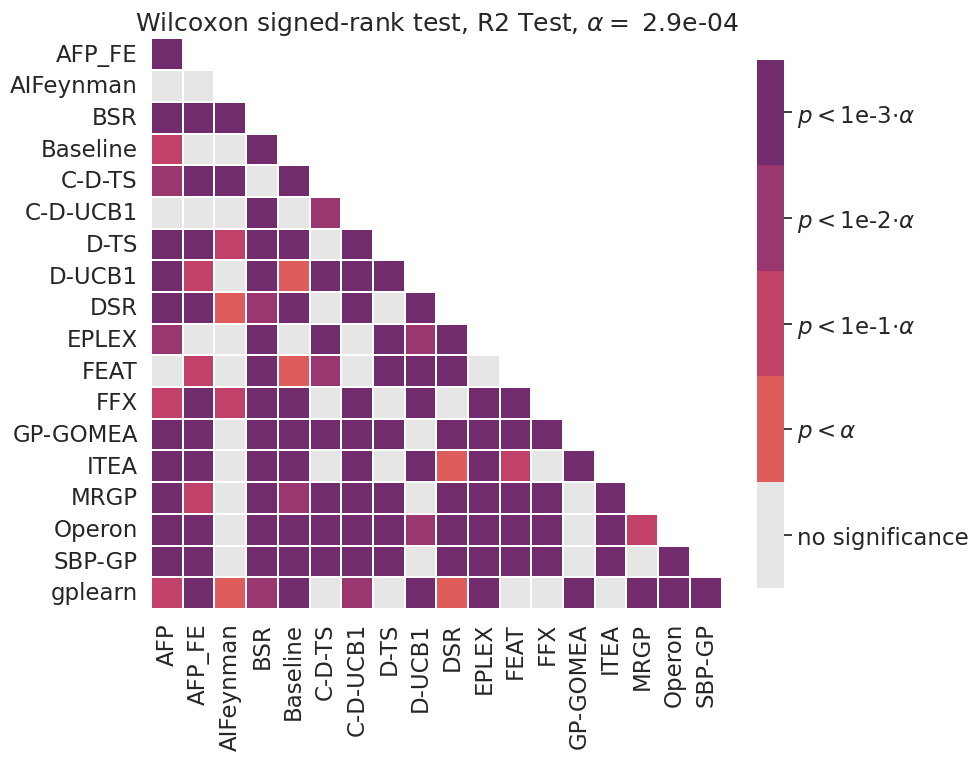

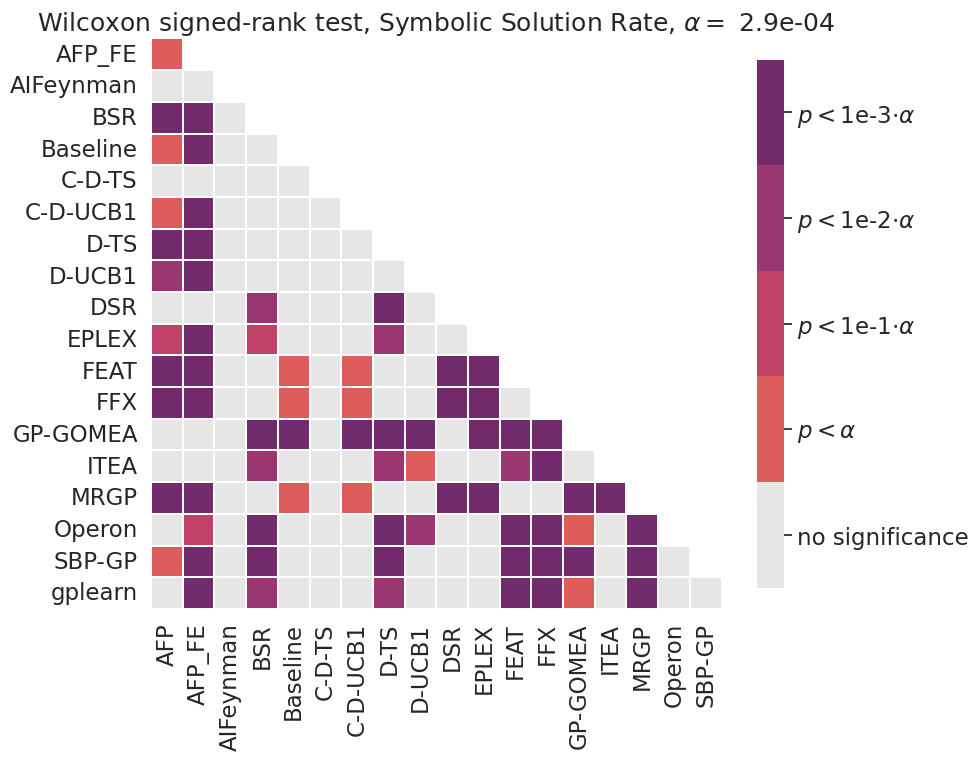

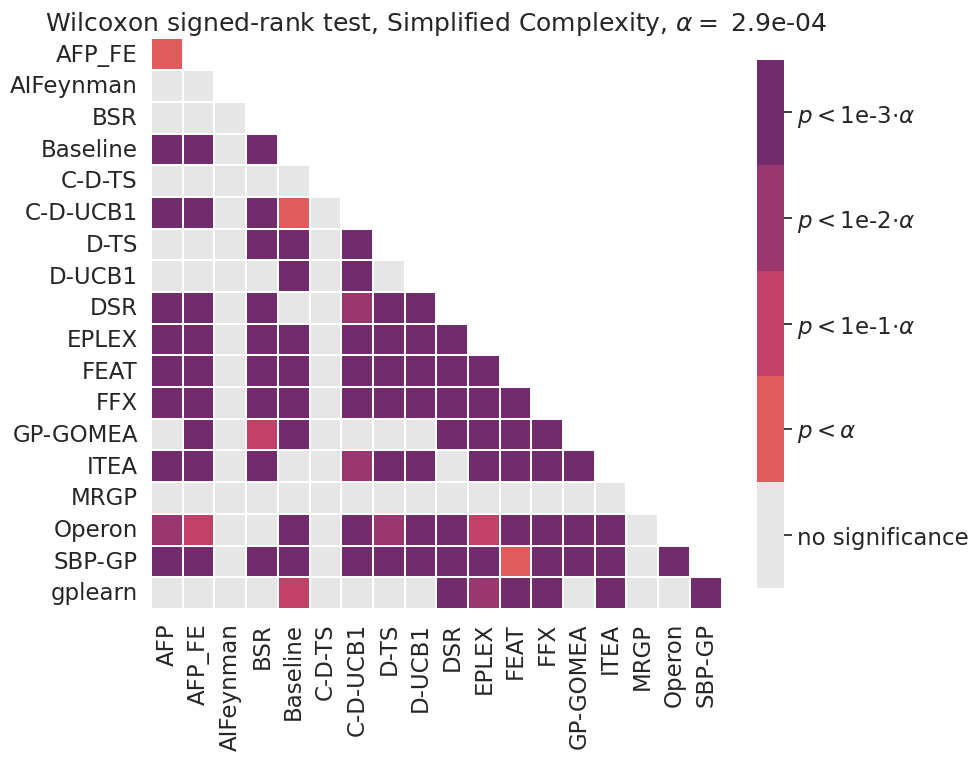

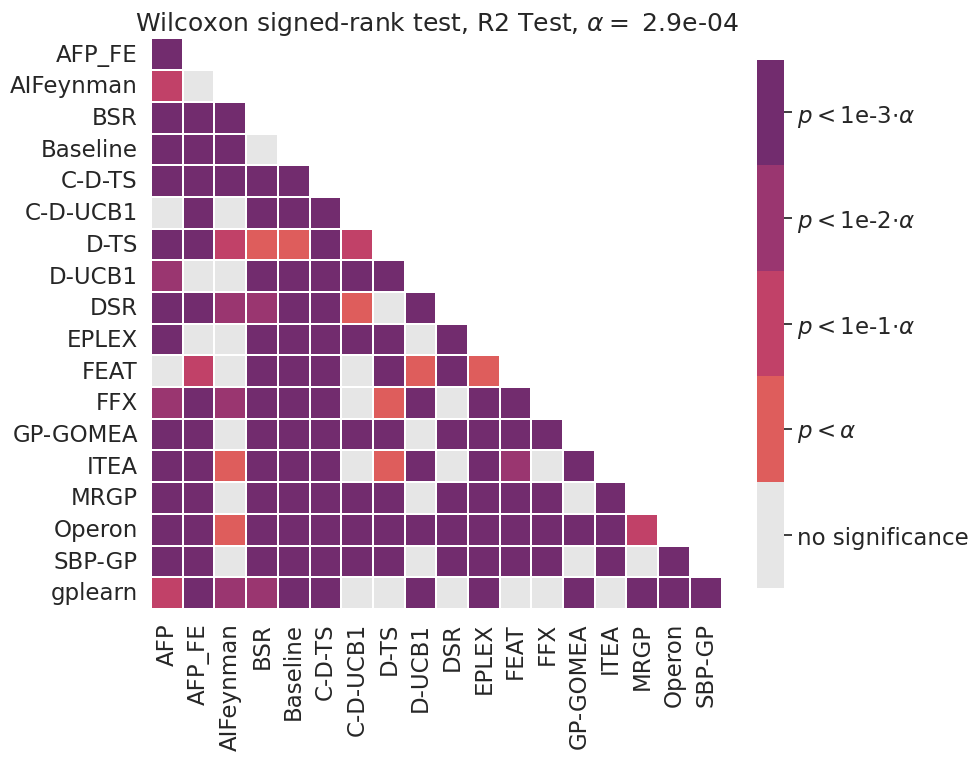

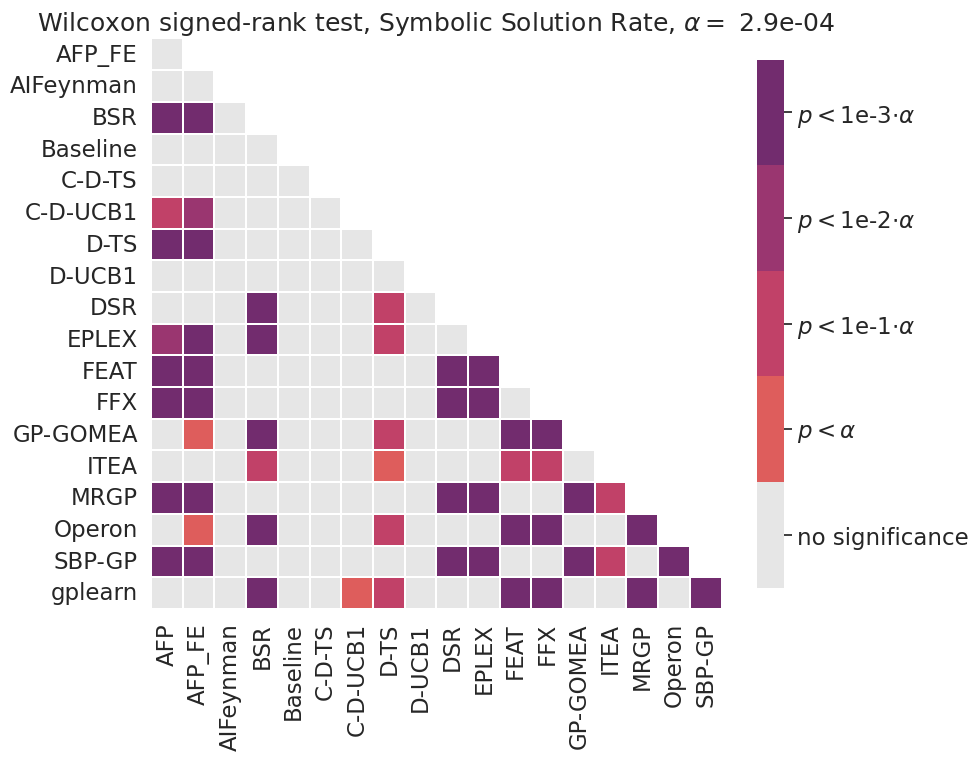

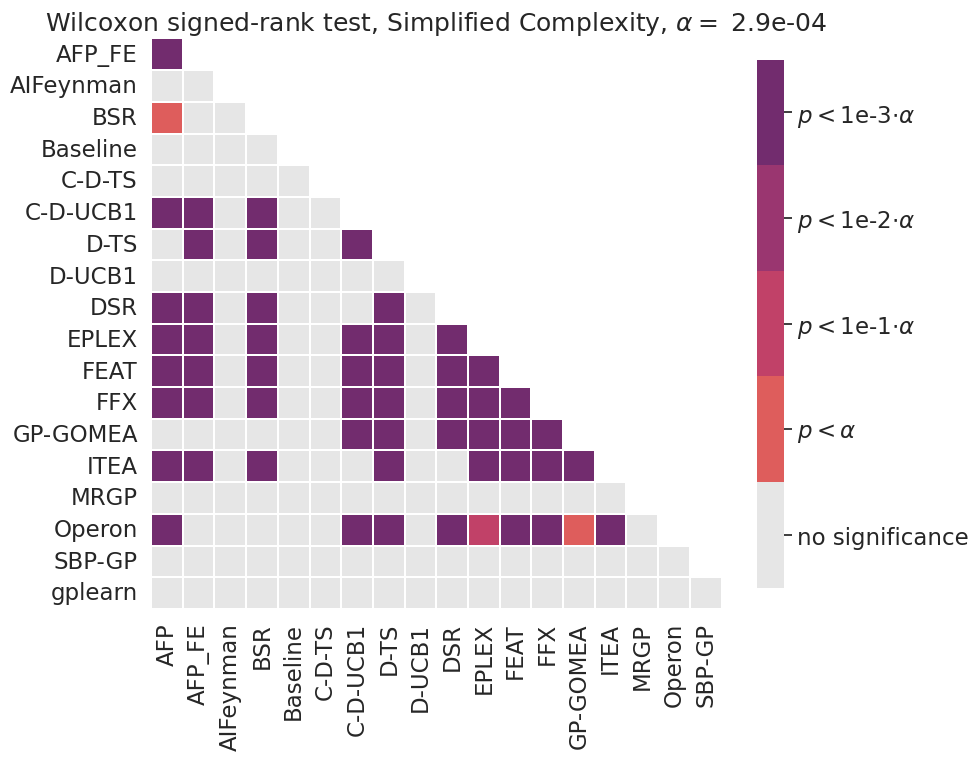

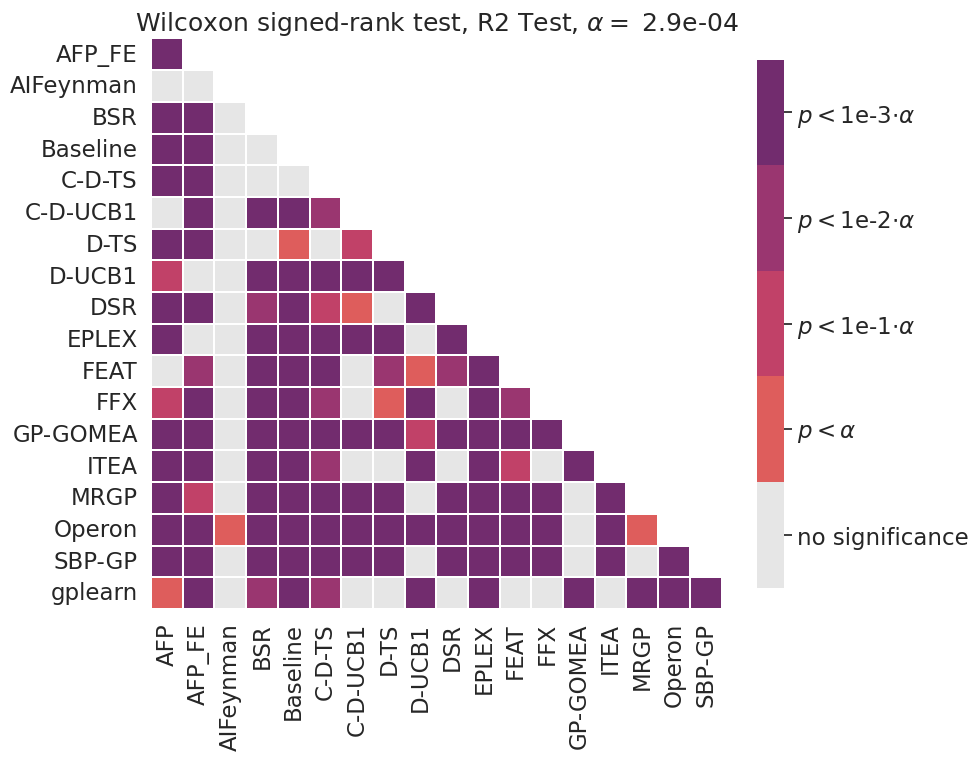

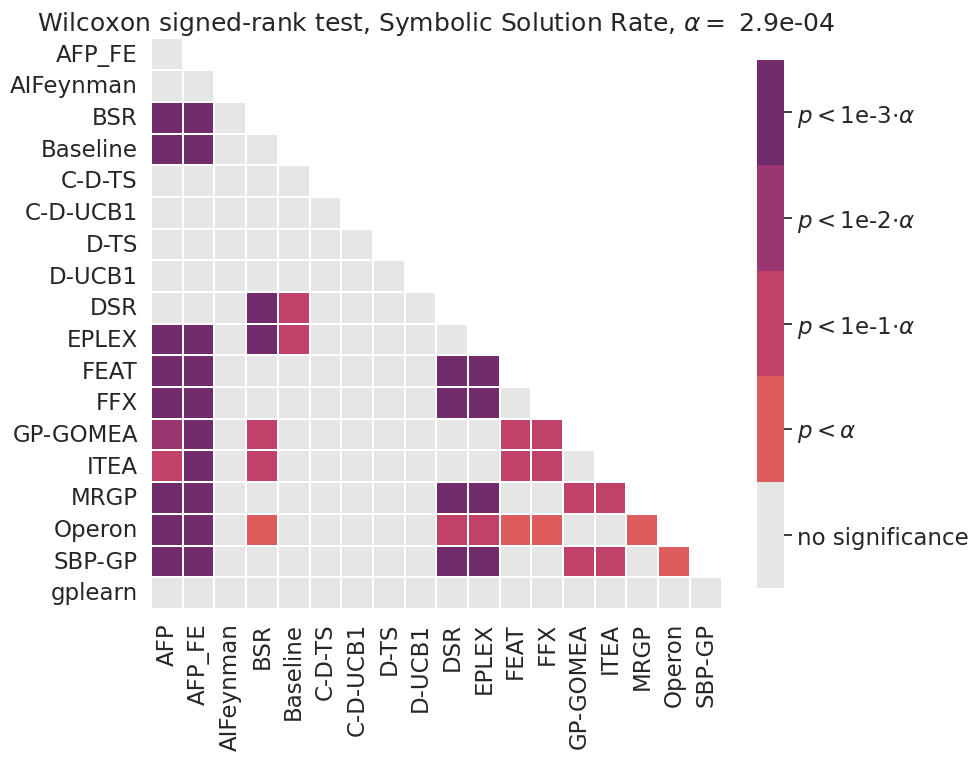

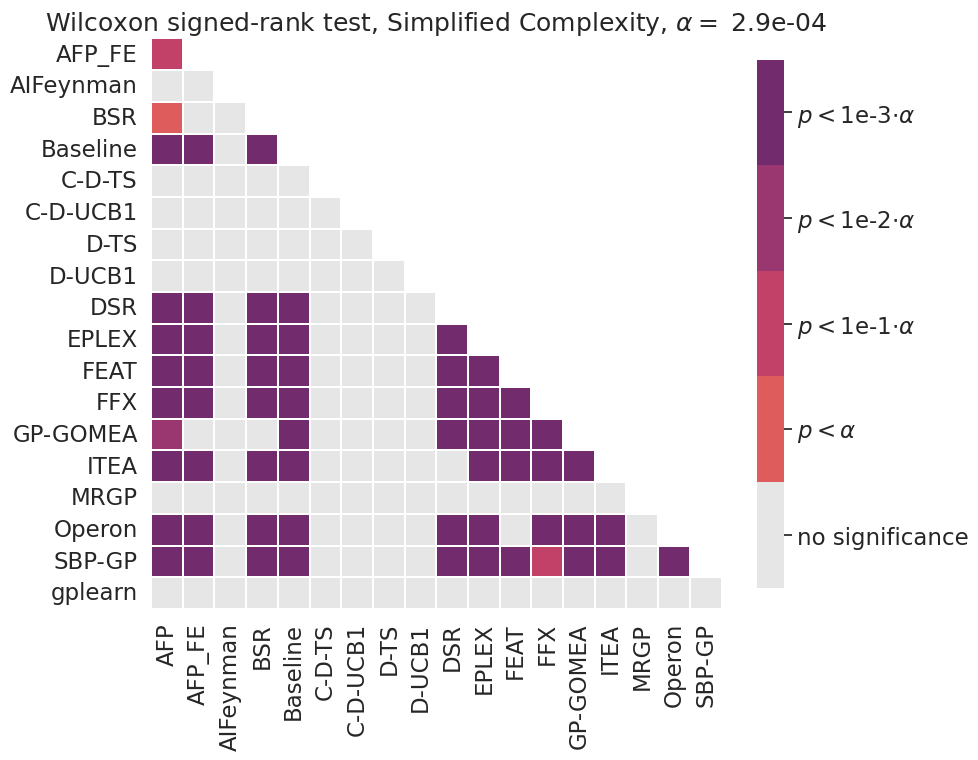

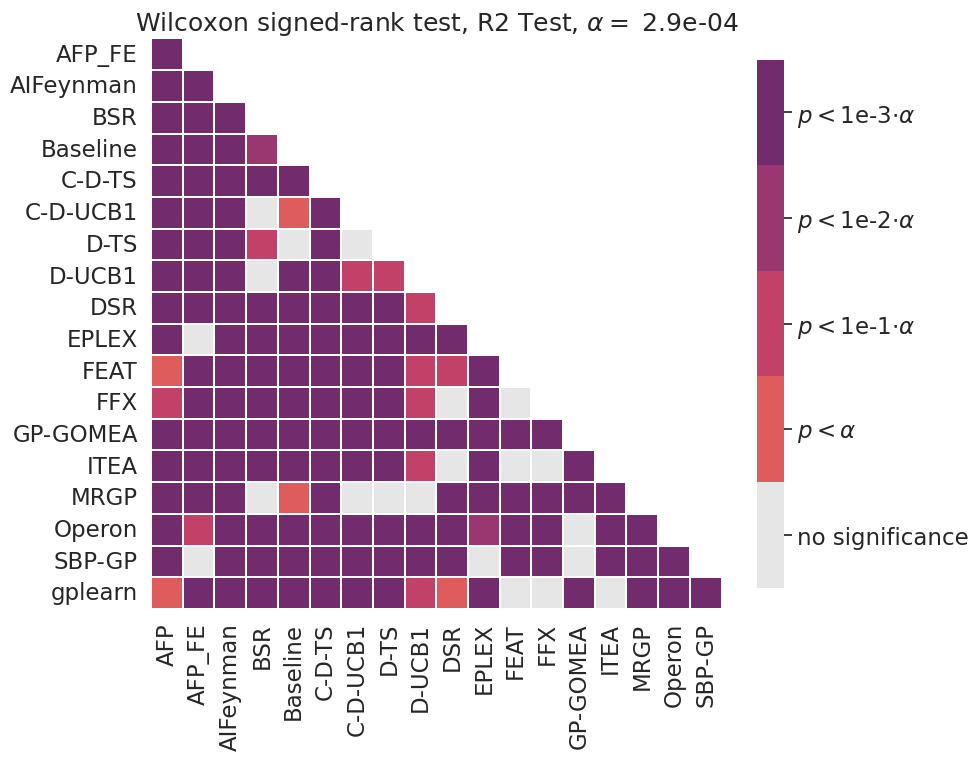

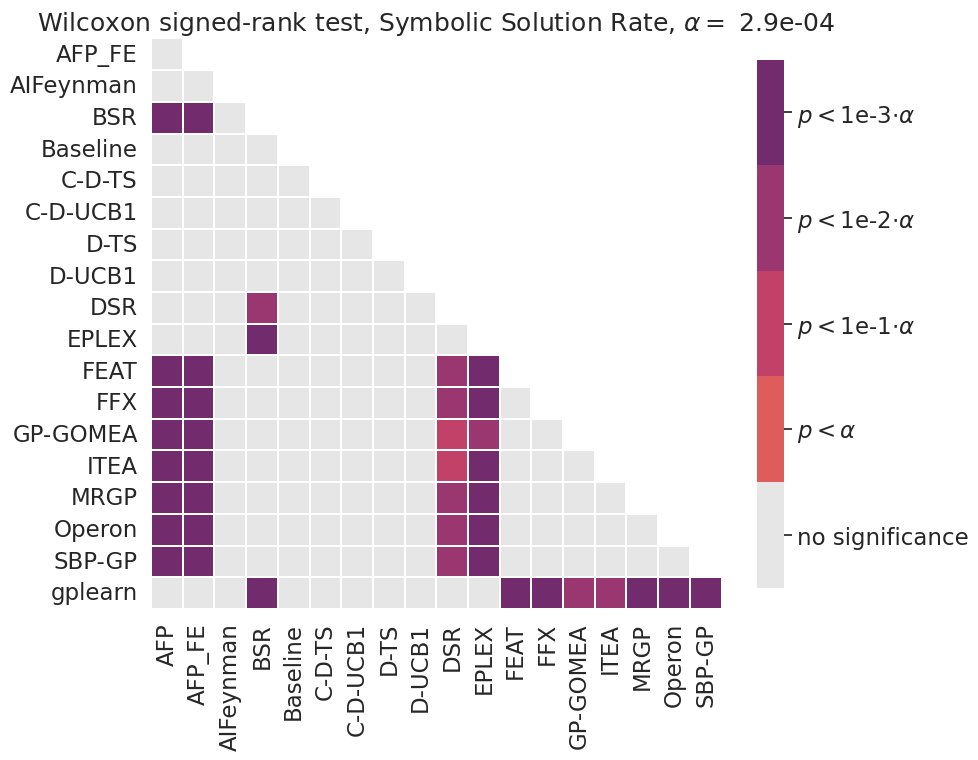

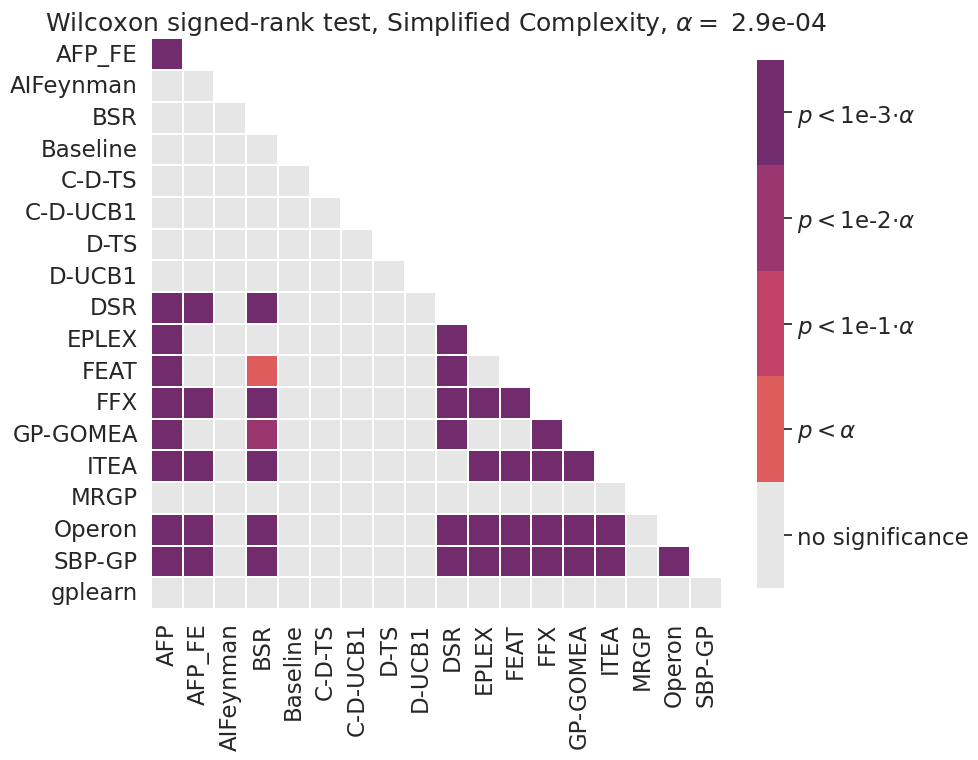

In [7]:
for target_noise, dfg in df_sum_filled.groupby('target_noise'):
    for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
        name = 'symbolic problems target_noise='+str(target_noise)
        pval_heatmap(dfg, metric, name, algs)
    

# Black-Box datasets

## load data and fill nan results

In [8]:
df_sum = pd.read_csv(rdir+'/results_black-box_summary.csv.gz')
algs = df_sum.algorithm.unique()
datasets = df_sum.dataset.unique()

cols = df_sum.columns
for col in [c for c in cols if 'rank' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(len(algs)+1)
for col in [c for c in cols if 'solution_rate' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(0.0)

df_sum

,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_test_rank,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,AFP,1027_ESL,13879.5,1210.966865,0.365049,0.442612,0.830930,20.5,0.336380,0.830930,...,19.0,0.939865,11.0,0.000770,19.0,0.939865,19.0,0.118757,19.0,0.105084
1,AFP,1028_SWD,13879.5,3017.658321,0.438023,0.538419,0.314517,47.0,0.838238,0.314517,...,19.0,0.824175,15.0,0.000378,19.0,0.795878,22.0,0.216281,22.0,0.208446
2,AFP,1029_LEV,13879.5,2622.206193,0.433124,0.508817,0.521904,23.5,0.728391,0.521904,...,19.0,0.939429,12.5,0.000229,19.0,0.934869,18.0,0.075079,18.0,0.070631
3,AFP,1030_ERA,13879.5,3007.024177,2.496171,1.299746,0.358716,36.5,0.835284,0.358716,...,19.0,0.919178,16.0,0.003315,19.0,0.917586,17.0,0.064576,17.5,0.068639
4,AFP,1089_USCrime,13879.5,590.939726,549.423049,18.823004,0.639671,25.0,0.164150,0.639671,...,21.0,0.822717,13.0,0.001007,21.0,0.780937,19.0,0.200320,19.0,0.286474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3394,uDSR,687_sleuth_ex1605,16322.5,467.736557,136.690742,9.560274,0.186892,16.0,0.129927,0.186892,...,17.0,0.993926,9.0,0.000238,17.0,0.389935,17.0,0.022411,17.0,0.073335
3395,uDSR,690_visualizing_galaxy,16322.5,380.951180,676.721353,21.075751,0.920812,11.5,0.105820,0.920812,...,23.5,0.795384,2.0,0.000025,23.5,0.795384,23.0,0.320382,23.0,0.457779
3396,uDSR,695_chatfield_4,16322.5,223.893122,307.115915,12.377622,0.832787,6.0,0.062193,0.832787,...,13.5,0.996855,4.5,0.000023,13.5,0.962087,9.0,0.009832,9.0,0.035854
3397,uDSR,706_sleuth_case1202,16322.5,344.079375,3582.665264,41.594337,0.628823,10.5,0.095578,0.628823,...,4.0,0.998603,6.0,0.000523,4.0,0.945908,10.0,0.018314,10.0,0.057651


In [9]:
# Picking only regression datasets

print(df_sum.shape)

# grab regression datasets
from yaml import load, Loader
data_dir = "../datasets/pmlb/datasets/"
for dataset in datasets:
    # print(data_dir+dataset+'/metadata.yaml')
    metadata = load(
        open(data_dir+dataset+'/metadata.yaml','r'),
            Loader=Loader)
    if metadata['task'] != 'regression':
        df_sum = df_sum.loc[df_sum.dataset != dataset]
        
print(df_sum.shape)

# if a result is missing, assign it the worst ranking
# cols = df_sum.columns
filler_frame = {
    'r2_test_rank' : len(algs)+1,
    'model_size_rank' : len(algs)+1,
    'r2_test' : 0.0,
}
fill_frames = []
j = 0
for dataset in datasets:
    for alg in algs:
        df = df_sum.loc[df_sum.dataset == dataset]
        if alg not in df.algorithm.unique():
            print('filling',alg,'missing for',dataset)
#                 for col in cols:
            new_fill = filler_frame.copy()
            new_fill.update({
                             'algorithm' : alg,
                             'dataset  ' : dataset,
                             "model_size" : np.nan_to_num(np.max(df['model_size'])),
                             "rmse_test" : np.nan_to_num(np.max(df['rmse_test'])),
                            })
            print(new_fill)
            fill_frames.append(new_fill)
            j += 1
            
df_fill = pd.DataFrame.from_records(fill_frames, columns=fill_frames[0].keys()) 
df_sum_filled = df_sum.append(df_fill)
df_sum_filled


(3399, 34)
(3399, 34)
filling NeSymRes 10M missing for 1027_ESL
{'r2_test_rank': 31, 'model_size_rank': 31, 'r2_test': 0.0, 'algorithm': 'NeSymRes 10M', 'dataset  ': '1027_ESL', 'model_size': 21441.0, 'rmse_test': 1.3001343450236351}
filling NeSymRes 10M missing for 1028_SWD
{'r2_test_rank': 31, 'model_size_rank': 31, 'r2_test': 0.0, 'algorithm': 'NeSymRes 10M', 'dataset  ': '1028_SWD', 'model_size': 121583.0, 'rmse_test': 0.8074651695275027}
filling NeSymRes 10M missing for 1029_LEV
{'r2_test_rank': 31, 'model_size_rank': 31, 'r2_test': 0.0, 'algorithm': 'NeSymRes 10M', 'dataset  ': '1029_LEV', 'model_size': 98129.0, 'rmse_test': 0.9769341427431774}
filling NeSymRes 10M missing for 1030_ERA
{'r2_test_rank': 31, 'model_size_rank': 31, 'r2_test': 0.0, 'algorithm': 'NeSymRes 10M', 'dataset  ': '1030_ERA', 'model_size': 10708.5, 'rmse_test': 2.0134983340688364}
filling NeSymRes 10M missing for 1089_USCrime
{'r2_test_rank': 31, 'model_size_rank': 31, 'r2_test': 0.0, 'algorithm': 'NeSymRes 

/tmp/ipykernel_914689/2260467847.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sum_filled = df_sum.append(df_fill)


,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm,dataset
0,AFP,1027_ESL,13879.5,1210.966865,0.365049,0.442612,0.830930,20.5,0.336380,0.830930,...,0.939865,11.0,0.000770,19.0,0.939865,19.0,0.118757,19.0,0.105084,NaN
1,AFP,1028_SWD,13879.5,3017.658321,0.438023,0.538419,0.314517,47.0,0.838238,0.314517,...,0.824175,15.0,0.000378,19.0,0.795878,22.0,0.216281,22.0,0.208446,NaN
2,AFP,1029_LEV,13879.5,2622.206193,0.433124,0.508817,0.521904,23.5,0.728391,0.521904,...,0.939429,12.5,0.000229,19.0,0.934869,18.0,0.075079,18.0,0.070631,NaN
3,AFP,1030_ERA,13879.5,3007.024177,2.496171,1.299746,0.358716,36.5,0.835284,0.358716,...,0.919178,16.0,0.003315,19.0,0.917586,17.0,0.064576,17.5,0.068639,NaN
4,AFP,1089_USCrime,13879.5,590.939726,549.423049,18.823004,0.639671,25.0,0.164150,0.639671,...,0.822717,13.0,0.001007,21.0,0.780937,19.0,0.200320,19.0,0.286474,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,NeSymRes 10M,NaN,NaN,NaN,NaN,NaN,0.000000,56674.0,NaN,NaN,...,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,687_sleuth_ex1605
197,NeSymRes 10M,NaN,NaN,NaN,NaN,NaN,0.000000,296346.0,NaN,NaN,...,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,690_visualizing_galaxy
198,NeSymRes 10M,NaN,NaN,NaN,NaN,NaN,0.000000,218870.0,NaN,NaN,...,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,695_chatfield_4
199,TPSR+E2E,NaN,NaN,NaN,NaN,NaN,0.000000,218870.0,NaN,NaN,...,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,695_chatfield_4


## generate tables

In [10]:
# baseline significance threshold; adjusted for no. of comparisons below
alpha = 0.05
BB_pvals = {}

for metric in ['r2_test','model_size']:
    pvals = []

    n = 0 
    df_pvals, c_alpha = get_pval_df(df_sum_filled, metric, algs) 
    pval_tbl = df_pvals.set_index(['alg1','alg2'])['pval'].unstack() 
    BB_pvals[metric] = pval_tbl.copy() 
    pval_tbl = pval_tbl.fillna('-')
    display(pval_tbl)
   
    pval_tbl

/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 435 c_alpha: 0.00011494252873563219


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


alg2,AFP_FE,AIFeynman,AdaBoost,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,...,MLP,MRGP,NeSymRes 10M,Operon,RandomForest,SBP-GP,TPSR+E2E,XGB,gplearn,uDSR
alg1,,,,,,,,,,,,,,,,,,,,,
AFP,0.484403,0.0,0.0,0.0,0.0,0.0,0.0,0.058648,0.0,0.0,...,0.004756,0.000695,0.0,0.0,0.000098,0.0,0.0,0.0,0.0,6.518706e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.001948,0.0,0.0,...,0.001601,0.000254,0.0,0.0,0.000287,0.0,0.0,0.0,0.0,1.095407e-16
AIFeynman,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,2.951407e-17
AdaBoost,-,-,-,0.0,0.0,0.001023,0.0,0.0,0.0,0.0,...,0.000058,0.0,0.0,0.0,0.929049,0.0,0.0,0.0,0.0,2.698264e-18
BSR,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.407963e-18
Baseline,-,-,-,-,-,0.0,0.0,0.0,0.000281,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053919,0.0,2.235628e-19
C-D-TS,-,-,-,-,-,-,0.0,0.0,0.0,0.0,...,0.000017,0.0,0.0,0.0,0.143208,0.0,0.0,0.0,0.0,5.131287e-19
C-D-UCB1,-,-,-,-,-,-,-,0.0,0.0,0.0,...,0.000003,0.0,0.0,0.0,0.00095,0.0,0.0,0.0,0.0,7.137519e-19
D-TS,-,-,-,-,-,-,-,-,0.0,0.000101,...,0.007043,0.02838,0.0,0.0,0.000032,0.0,0.0,0.0,0.000007,1.050830e-04


n: 435 c_alpha: 0.00011494252873563219


alg2,AFP_FE,AIFeynman,AdaBoost,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,...,MLP,MRGP,NeSymRes 10M,Operon,RandomForest,SBP-GP,TPSR+E2E,XGB,gplearn,uDSR
alg1,,,,,,,,,,,,,,,,,,,,,
AFP,0.243734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000278,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.271905e-20
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011104,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.942037e-21
AIFeynman,-,-,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.231369,0.00005,0.0,0.0,0.0,0.000001,0.084288,0.000009,0.0,6.800777e-19
AdaBoost,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.300924,0.0,0.0,0.0,0.0,0.000501,0.082509,0.0,1.969714e-21
BSR,-,-,-,-,0.00006,0.010044,0.000015,0.000757,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068377,3.141133e-19
Baseline,-,-,-,-,-,0.0,0.003719,0.092636,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.229090e-18
C-D-TS,-,-,-,-,-,-,0.0,0.000098,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,6.237429e-17
C-D-UCB1,-,-,-,-,-,-,-,0.007018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.667975e-18
D-TS,-,-,-,-,-,-,-,-,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.356361e-18


/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_914689/887026745.py:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 435 c_alpha: 0.00011494252873563219
saving figs/stats//Pairwise_comparison_of_R2_Test_on_black-box_problems.png
n: 435 c_alpha: 0.00011494252873563219
saving figs/stats//Pairwise_comparison_of_Model_Size_on_black-box_problems.png
n: 435 c_alpha: 0.00011494252873563219
saving figs/stats//Pairwise_comparison_of_Rmse_Test_on_black-box_problems.png


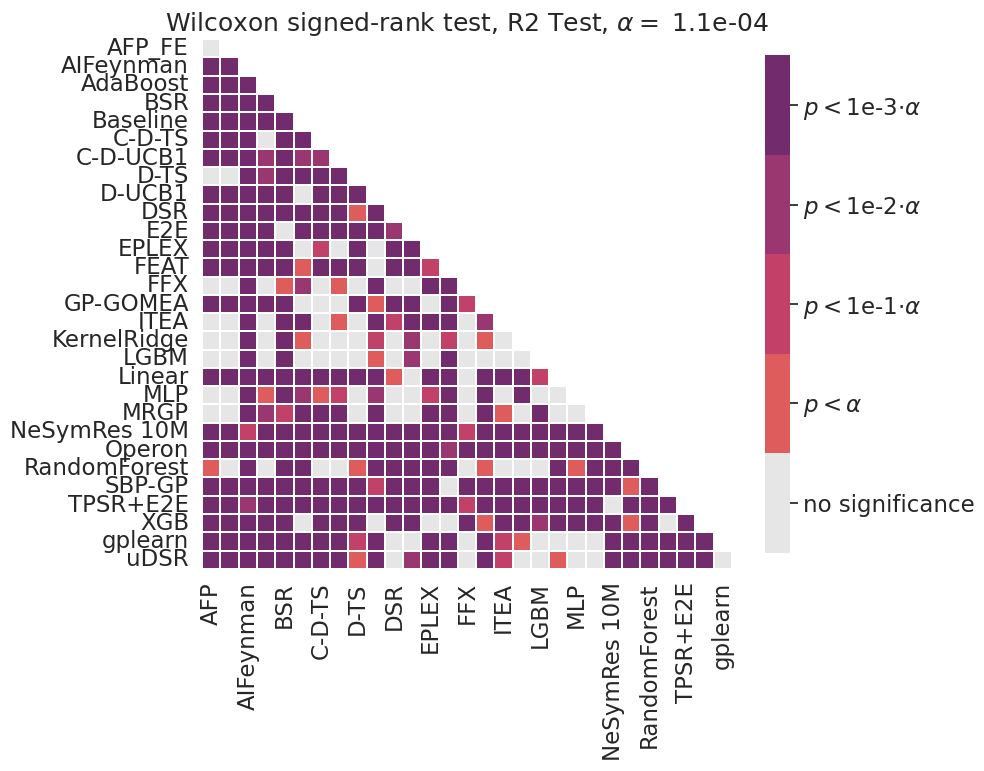

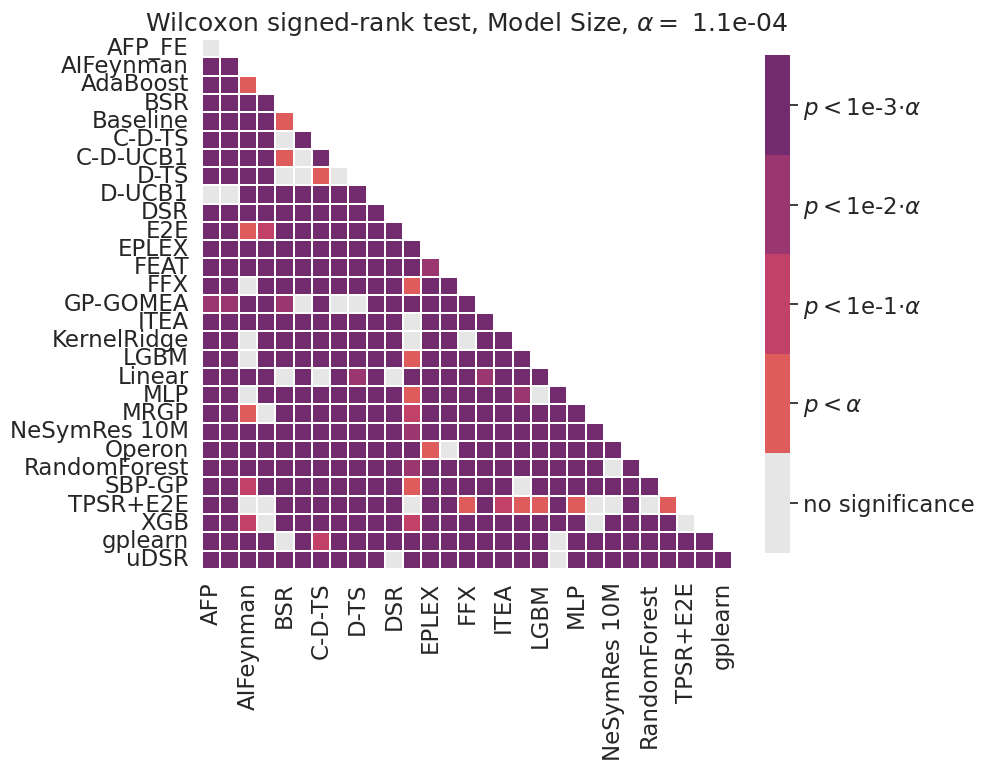

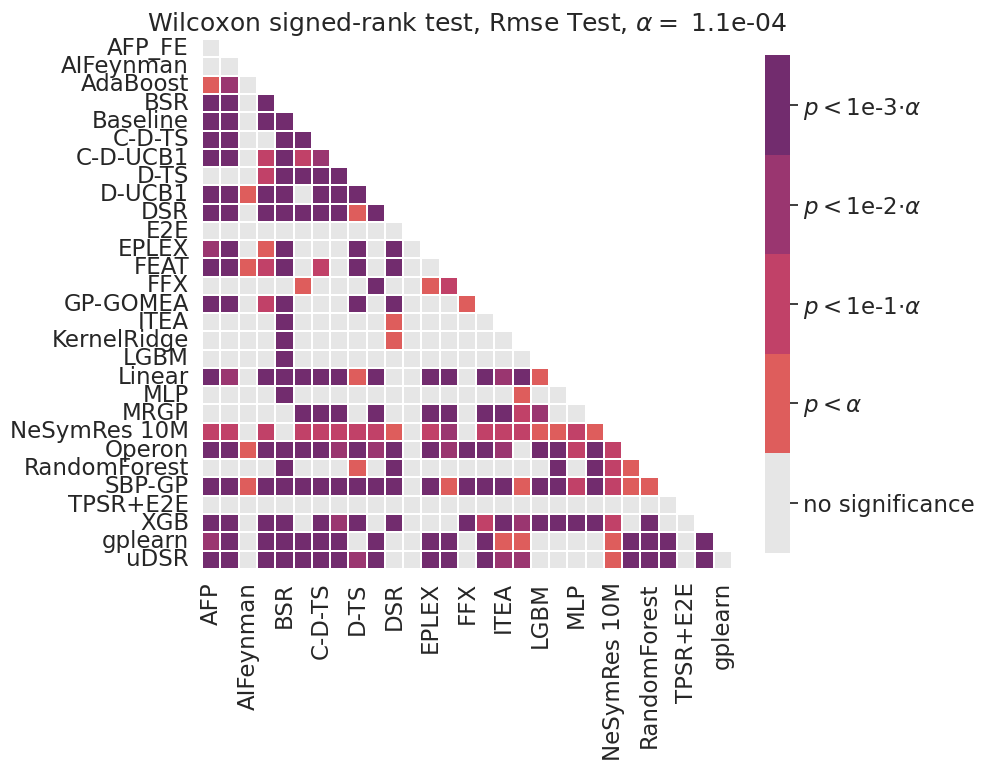

In [11]:
for metric in ['r2_test','model_size', 'rmse_test']:
    name = 'black-box problems'
    pval_heatmap(df_sum_filled, metric, name, algs)

## specific p-values referenced in manuscript

In [12]:
# first fill the matrices so we can look at either pair
for k,v in BB_pvals.items():
    algs = v.columns
    for alg1, alg2 in it.combinations(algs,2):
        if np.isnan(BB_pvals[k].loc[alg1,alg2]): 
            BB_pvals[k].loc[alg1,alg2] = BB_pvals[k].loc[alg2,alg1] 
        else:
            BB_pvals[k].loc[alg2,alg1] = BB_pvals[k].loc[alg1,alg2] 

Operon performance on BB problems

In [13]:
BB_pvals['r2_test']['Operon'].max() 

7.421437759183752e-05

FEAT model size vs SGP

In [14]:
BB_pvals['model_size'].loc['FEAT','SBP-GP']

1.9717200682257908e-21

Operon, SBP significantly outperform LGBM

In [15]:
BB_pvals['r2_test'].loc['XGB',['Operon','SBP-GP']].max() #.replace('-','0').astype(float).max() #.round(2)

0.0001301536115369823

Operon, SBP, and FEAT significantly outperform LGBM

In [16]:
BB_pvals['r2_test'].loc['LGBM',['Operon','FEAT','SBP-GP']].max() #.replace('-','0').astype(float).max() #.round(2)

6.281807502267311e-08

GP models smaller than ensemble tree methods

In [17]:
import itertools as it
import numpy as np

gps = ['Operon','FEAT','EPLEX','ITEA','GP-GOMEA']
trees = ['LGBM','XGB','RandomForest','AdaBoost']
BB_pvals['model_size'].loc[gps,trees].max().max()


2.8741290241700236e-21

In [18]:
BB_pvals['r2_test'].loc[['DSR','BSR','FFX','AIFeynman'],['DSR','BSR','FFX','AIFeynman']]

alg2,DSR,BSR,FFX,AIFeynman
alg1,,,,
DSR,NaN,3.046786e-19,8.320069e-01,2.522184e-17
BSR,3.046786e-19,NaN,9.331289e-05,5.006495e-11
FFX,8.320069e-01,9.331289e-05,NaN,4.318578e-09
AIFeynman,2.522184e-17,5.006495e-11,4.318578e-09,NaN


In [19]:
BB_pvals['r2_test'].loc[['DSR','FFX'],['BSR','AIFeynman']]

alg2,BSR,AIFeynman
alg1,,
DSR,3.046786e-19,2.522184e-17
FFX,9.331289e-05,4.318578e-09


In [20]:
BB_pvals['r2_test'][['BSR','AIFeynman']]

alg2,BSR,AIFeynman
alg1,,
AFP,7.413392e-21,3.399810e-18
AFP_FE,1.186251e-20,2.140313e-18
AIFeynman,5.006495e-11,NaN
AdaBoost,7.231731e-21,3.430979e-19
BSR,NaN,5.006495e-11
Baseline,9.265242e-21,1.803153e-19
C-D-TS,2.603875e-20,3.271873e-19
C-D-UCB1,2.871365e-20,2.770308e-19
D-TS,1.453540e-19,6.928576e-18
